In [255]:
import pandas as pd
import numpy as np
import pm4py
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from collections import Counter


log = pm4py.read_xes("./3_waymatch_invoicebeforeGR_StandardPO.xes")
log_frozen = log

parsing log, completed traces :: 100%|██████████| 178600/178600 [00:42<00:00, 4235.55it/s]


Analyzing the 3-way match, Invoice before Good Receipt Standard Po process, we observe that 550 different resources are involved, of which 17 are automated batch processes 532 are human users and for missing resource it is 'NONE'.

In [256]:
print(log["org:resource"].nunique())
print(log[log["org:resource"].str.startswith("batch")]["org:resource"].nunique())
print(log[log["org:resource"].str.startswith("user")]["org:resource"].nunique())
print(log[~(log["org:resource"].str.startswith("batch") | log["org:resource"].str.startswith("user"))]["org:resource"].unique())

550
17
532
['NONE']


First, we aim to understand and handle missing values. We want answer the questions, what activities are affected and to which degree, and if there is a difference across spend areas.

The figure summarizes the results. We can observe that user is always missing in the events *Vendor creates debit memo* and *Vendor creates invoice*. This makes sense, since the resource is outside the company, its the vendor. In BPMN it would be best represented as a message received event. We keep this in mind for the simulation, possibly assigning a role vendor. For the analysis of responsibilities we can simply remove all events belonging to these activities.

However, in clear invoice a missing value for the user in 4.2% of cases is not as obvious to explain. Having our objective in mind, which is to explore responsibilities, we can simply remove the affected events, without any further implications. It's not necessary to remove the whole case, since these might provide valuable information in regard to responsibilities.

case:Spend area text       Other  Packaging  Sales
concept:name                                      
Clear Invoice               2411       2598   2439
Vendor creates debit memo   2089       1039   1694
Vendor creates invoice     46487      74190  54120
concept:name
Clear Invoice                177497
Vendor creates debit memo      4822
Vendor creates invoice       174797
dtype: int64
concept:name
Clear Invoice                0.041961
Vendor creates debit memo    1.000000
Vendor creates invoice       1.000000
dtype: float64


<Figure size 1200x600 with 0 Axes>

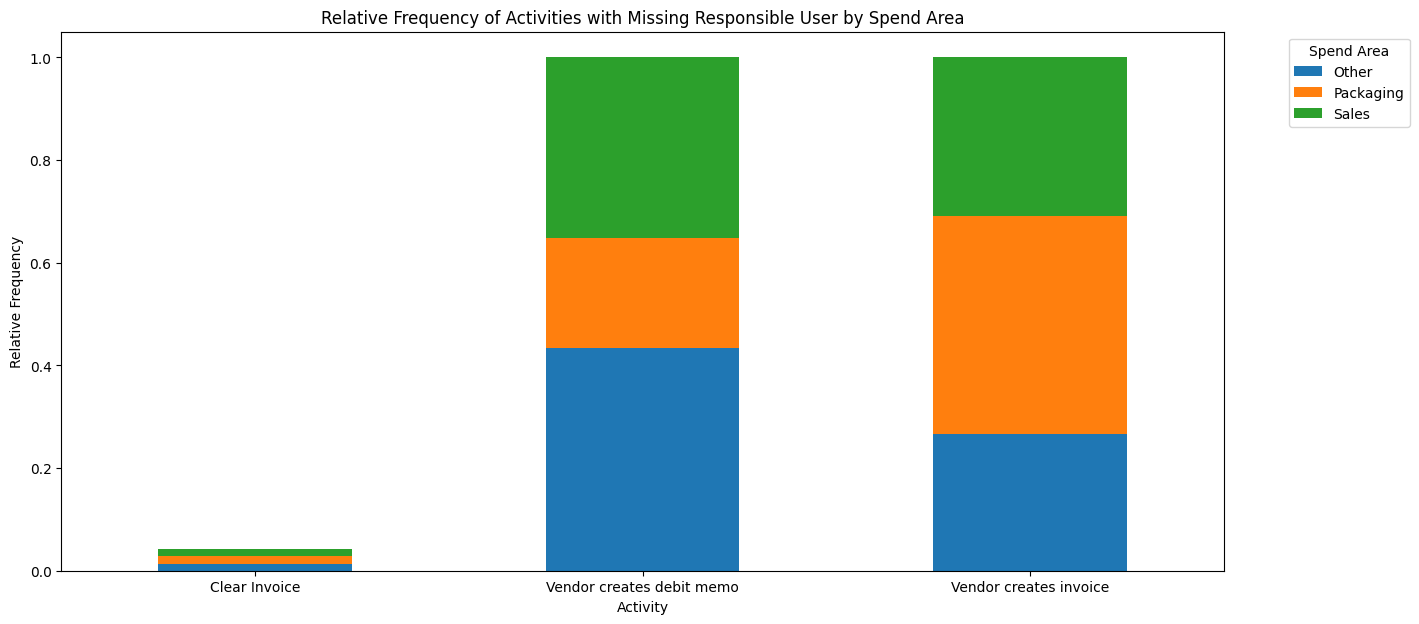

Number of cases affected by missing values in 'Clear Invoice': 7448
Number of cases in the log: 178600
Affected cases percent: 4.17%


In [257]:
# Replace 'NONE' with missing values
log.replace("NONE", None, inplace=True)

none_activities_spend_area = log[log["org:resource"].isnull()].pivot_table(
    index="concept:name", columns="case:Spend area text", aggfunc="size", fill_value=0
)
print(none_activities_spend_area)


total_occurrences_independent = log.pivot_table(
    index="concept:name", aggfunc="size", fill_value=0
).reindex(none_activities_spend_area.index)
print(total_occurrences_independent)

relative_none_activities_spend_area = none_activities_spend_area.div(
    total_occurrences_independent, axis=0
)

print(relative_none_activities_spend_area.sum(axis=1))

plt.figure(figsize=(12, 6))
ax = relative_none_activities_spend_area.plot(kind="bar", stacked=True, figsize=(15, 7))
plt.title(
    "Relative Frequency of Activities with Missing Responsible User by Spend Area"
)
plt.xlabel("Activity")
plt.ylabel("Relative Frequency")
plt.legend(title="Spend Area", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=0, ha="center")
plt.show()

affected_cases_clear_invoice = log[
    (log["concept:name"] == "Clear Invoice") & (log["org:resource"].isnull())
]["case:concept:name"].nunique()
print(
    f"Number of cases affected by missing values in 'Clear Invoice': {affected_cases_clear_invoice}"
)

number_of_cases = log["case:concept:name"].nunique()
print(f"Number of cases in the log: {number_of_cases}")

print(
    f"Affected cases percent: {round(affected_cases_clear_invoice / number_of_cases * 100, 2)}%"
)

In [258]:
log2 = log[~((log["concept:name"] == "Clear Invoice") & (log["org:resource"].isnull()))]
print(
    (
        len(log[log["concept:name"] == "Clear Invoice"])
        - len(log2[log2["concept:name"] == "Clear Invoice"])
    )
    / len(log[log["concept:name"] == "Clear Invoice"])
)

log2 = log2[
    ~(
        log2["concept:name"].isin(
            ["Vendor creates invoice", "Vendor creates debit memo"]
        )
    )
]
print(log2["concept:name"].unique())

log = log2
print(len(log[log["org:resource"].isnull()]))

0.041961272584888756
['Create Purchase Order Item' 'Receive Order Confirmation'
 'Record Goods Receipt' 'Record Invoice Receipt' 'Clear Invoice'
 'Change Quantity' 'Change Delivery Indicator' 'Cancel Subsequent Invoice'
 'Remove Payment Block' 'Change Price' 'Cancel Invoice Receipt'
 'Delete Purchase Order Item' 'Reactivate Purchase Order Item'
 'Update Order Confirmation' 'Block Purchase Order Item'
 'Change Approval for Purchase Order' 'Release Purchase Order'
 'Cancel Goods Receipt' 'Record Subsequent Invoice'
 'Create Purchase Requisition Item' 'Set Payment Block'
 'Change Storage Location' 'Change Currency' 'Change payment term'
 'Release Purchase Requisition']
0


Next, we analyze the current state of automation to determine which activities are automated and to what extent, as well as any differences across the spend areas.

Our findings reveal that activities across all three spend areas are predominantly manual. Overall, batch processes are involved in 12 activities across all spend areas. The highest level of automation is observed in the Packaging spend area, where *Release Purchase Requisition* shows one-third of instances being automated. Beyond this, the only other activity with automation exceeding 10% is *Remove Payment Block*, and this exclusively within the Sales spend area.

Consequently, we identify a significant opportunity to enhance process quality by expanding automation to a larger portion of the process. Establishing a standardized framework for the already partially automated activities and extending automation to additional cases could enhance reliability, and reduce complexity and employee workload. This would enable employees to focus on more complex and valueable tasks. Furthermore, as automation is increased within the partially automated activities, it would be beneficial to analyze whether other activities could also be automated.

case:Spend area text              Other  Packaging  Sales
concept:name                                             
Cancel Goods Receipt                 74          0     28
Cancel Invoice Receipt                5         12      2
Change Quantity                       0          0      2
Create Purchase Order Item          759      10416    531
Create Purchase Requisition Item   1196       2207     66
Receive Order Confirmation            1       3767      0
Record Goods Receipt               8984       4119  11583
Record Invoice Receipt             1755       2927   2047
Record Subsequent Invoice             1          2      1
Release Purchase Requisition          0          1      0
Remove Payment Block               4199       4160   5373
Update Order Confirmation             0          4      0
case:Spend area text              Other  Packaging  Sales
concept:name                                             
Cancel Goods Receipt                540        433     79
Cancel Invoice

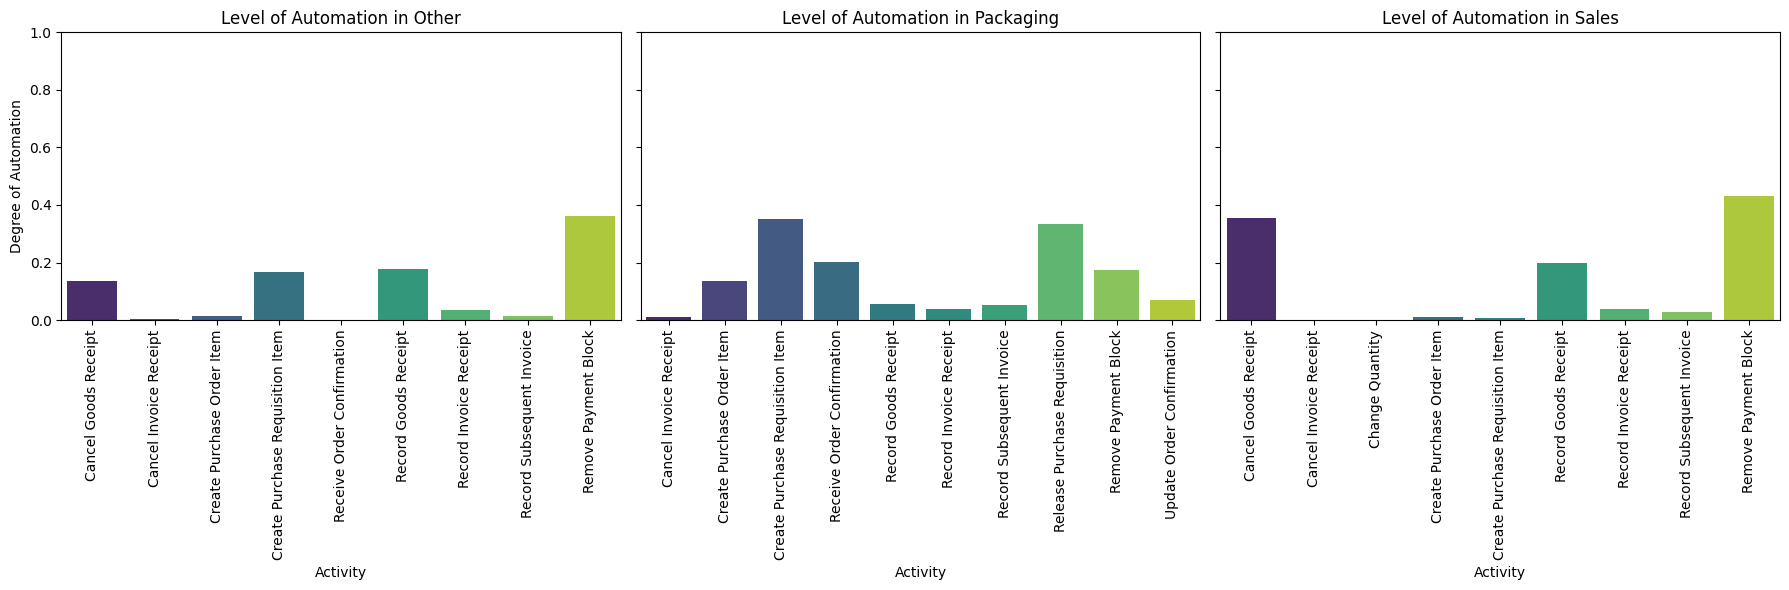

In [270]:
automated_activities = log[log["org:resource"].str.startswith("batch")]

automated_activities_spend_area = automated_activities.pivot_table(
    index="concept:name", columns="case:Spend area text", aggfunc="size", fill_value=0
)
print(automated_activities_spend_area)


# Correct total occurrences for reindexing
total_occurrences_spend_area = log.pivot_table(
    index="concept:name", columns="case:Spend area text", aggfunc="size", fill_value=0
).reindex(automated_activities_spend_area.index)
print(total_occurrences_spend_area)

relative_automated_activities_spend_area = automated_activities_spend_area.div(
    total_occurrences_spend_area, axis=0
)
print(relative_automated_activities_spend_area)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

for i, spend_area in enumerate(relative_automated_activities_spend_area.columns):
    data = relative_automated_activities_spend_area[spend_area]
    data = data[data > 0]
    sns.barplot(ax=axes[i], x=data.index, y=data.values, hue=data.index, legend=False, palette="viridis")
    axes[i].set_title(f"Level of Automation in {spend_area}")
    axes[i].set_xlabel("Activity")
    axes[i].set_ylabel("Degree of Automation")
    axes[i].set_ylim(0, 1)
    axes[i].tick_params(axis="x", rotation=90)

plt.xticks(rotation=90, ha="center")

plt.tight_layout()
plt.show()

Furthermore, we analyze the involvement of human users in the process by excluding all activities executed by batch processes and focusing solely on user-executed tasks. By examining the distribution of users across different activities and spend areas, we aim to identify patterns of responsibility. Specifically, we seek to answer key questions: Who is performing which activities? Conversely, which activities are primarily handled by specific users, and how many users are involved? Additionally, we explore whether there are notable differences across spend areas.

First, we investigate how the workload is distributed among users by calculating the total number of activities executed per user. The results reveal significant differences in process participation, with *user002* standing out as an extreme outlier, executing far more activities than any other user. Relative to this scale, the first three quartiles show very limited participation. To eliminate noise caused by rarely involved users, we filter out these extreme outliers and replot the histogram, enabling a clearer view of the activity distribution among the majority of users.

Our primary focus is on responsibilities, particularly for frequent tasks. Since none of the tasks are time-intensive, frequency becomes the critical factor for evaluating responsibility. To address noise caused by sporadic participation, such as users executing tasks temporarily due to vacation or other circumstances, we filter out the lower half of users, retaining only those with execution counts above the median (64). Given the scale of the process, which involves over 170,000 cases per year with assumed task durations averaging around 5 minutes, this filtering simplifies the analysis while preserving essential information about responsibilities.

Interestingly, the observation that more than half of the users rarely participate raises another opportunity for optimization. It is well understood that routine tasks are performed more efficiently with experience, whereas infrequent execution can lead to inefficiencies and longer completion times. While the current distribution of activities suggests that responsibilities are generally assigned (e.g., *user002*), the involvement of many users in sporadic execution prompts the question of why these assignments are not followed more strictly.

In real-world scenarios, some level of flexibility in task execution, such as purchasing required goods, is important. However, a more structured framework could strike a balance, preserving necessary flexibility while leveraging the benefits of experience and routine. Such improvements may enhance efficiency, reduce errors, and ensure that responsibilities are executed consistently and effectively.

org:resource
user_001     28087
user_002    152311
user_004      4421
user_005     13458
user_006     16064
dtype: int64
Upper bound outliers:  1241.5
Median:  64.0


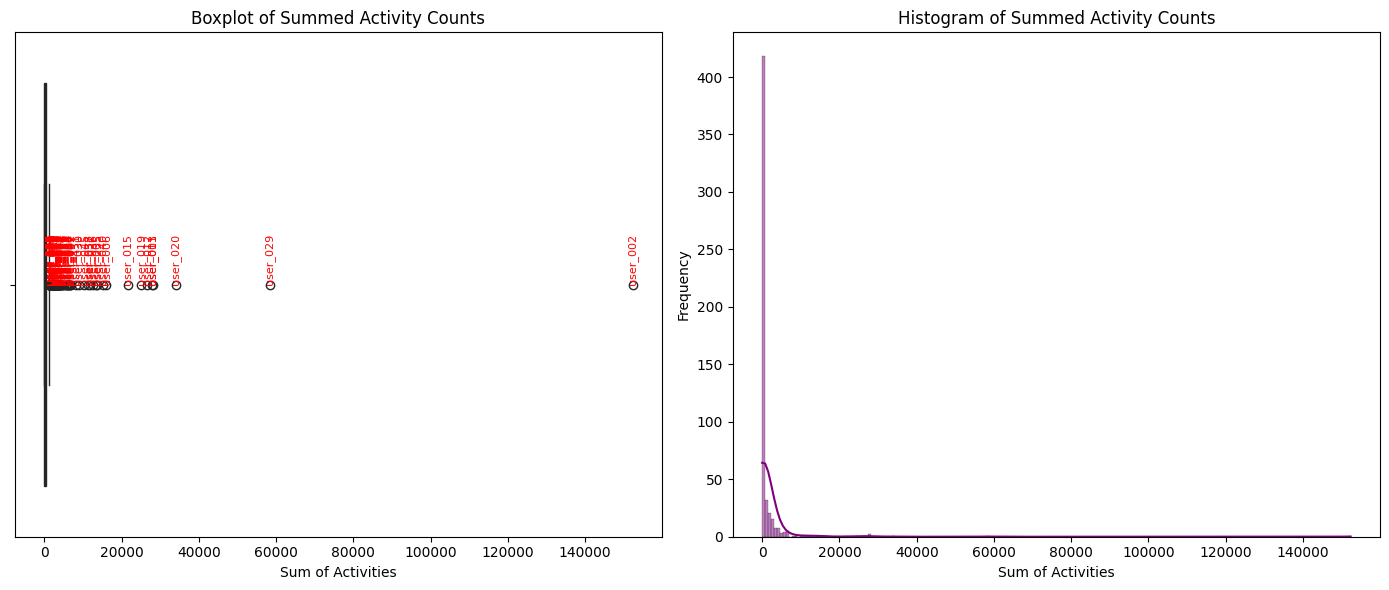

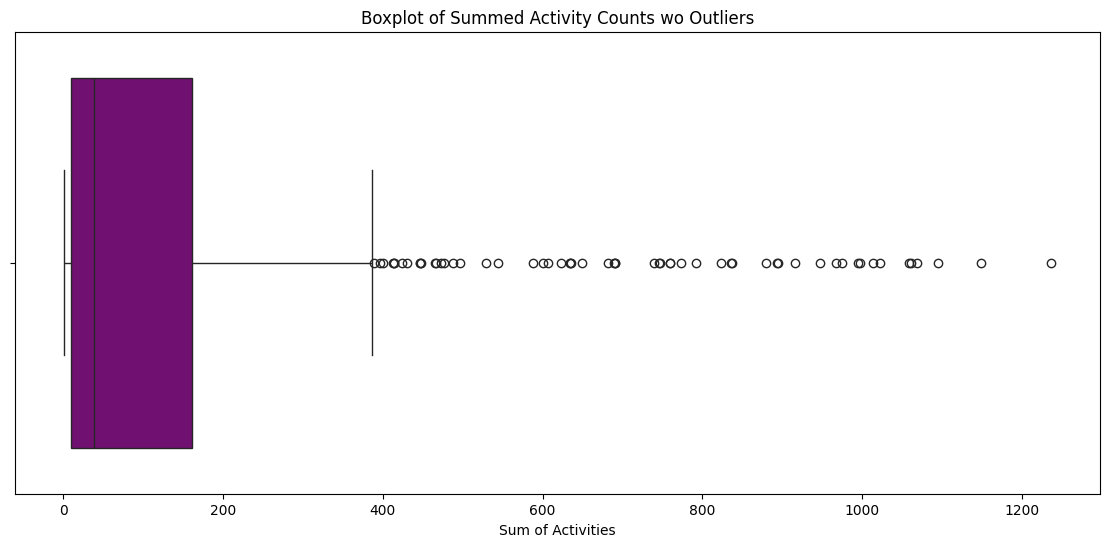

In [271]:
manual_activities = log[~log["org:resource"].str.startswith("batch")]

resource_activity_matrix = manual_activities.pivot_table(
    index="org:resource",
    columns="concept:name",
    aggfunc="size",
    fill_value=0,
)

row_sums = resource_activity_matrix.sum(axis=1)
print(row_sums.head())

Q1 = row_sums.quantile(0.25)
Q3 = row_sums.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
print("Upper bound outliers: ", upper_bound)
print("Median: ", row_sums.median())

outliers = row_sums[(row_sums < lower_bound) | (row_sums > upper_bound)]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(x=row_sums, color="purple", ax=axes[0])
axes[0].set_title("Boxplot of Summed Activity Counts")
axes[0].set_xlabel("Sum of Activities")

for idx, value in outliers.items():
    axes[0].text(
        value, 0, idx, ha="center", va="bottom", fontsize=8, rotation=90, color="red"
    )

sns.histplot(row_sums, bins=200, kde=True, color="purple", ax=axes[1])
axes[1].set_title("Histogram of Summed Activity Counts")
axes[1].set_xlabel("Sum of Activities")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x=row_sums[~row_sums.index.isin(outliers.index)], color="purple")
plt.title("Boxplot of Summed Activity Counts wo Outliers")
plt.xlabel("Sum of Activities")
plt.show()

In [272]:
print(manual_activities["org:resource"].nunique())
manual_activities = manual_activities[manual_activities["org:resource"].isin(row_sums[row_sums > row_sums.median()].index)]
print(manual_activities["org:resource"].nunique())

532
265


Analyzing the remaining half of users executing more than median events, we aim to determine whether there is an organizational separation between activities. Specifically, we investigate whether certain combinations of activities are predominantly executed by a distinct subset of users. To achieve this, we construct a pivot matrix where each cell is set to 1 if a user executed a given activity more than five times and 0 otherwise. The threshold of five serves to mitigate the influence of occasional execution due to factors like vacation or sickness and filters out noise from very rarely performed activities.

This transformation effectively scales the data, making it suitable for hierarchical clustering to identify patterns among users performing similar sets of activities. To determine the optimal distance threshold for cutting the dendrogram, we utilize the silhouette score. However, as unpenalized silhouette scores led to an impractical result of 65 clusters, we introduced a penalty proportional to the number of clusters to derive a more actionable and interpretable solution.

C:\Users\jojow\AppData\Local\Temp\ipykernel_17324\3116244161.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  binary_activity_matrix = resource_activity_matrix.applymap(lambda x: 1 if x > 5 else 0)


concept:name  Block Purchase Order Item  Cancel Goods Receipt  \
org:resource                                                    
user_001                              0                     0   
user_002                              0                     0   
user_004                              0                     0   
user_005                              0                     0   
user_006                              0                     0   

concept:name  Cancel Invoice Receipt  Cancel Subsequent Invoice  \
org:resource                                                      
user_001                           1                          1   
user_002                           0                          0   
user_004                           1                          1   
user_005                           0                          0   
user_006                           1                          1   

concept:name  Change Approval for Purchase Order  Change Currency  \
org:r

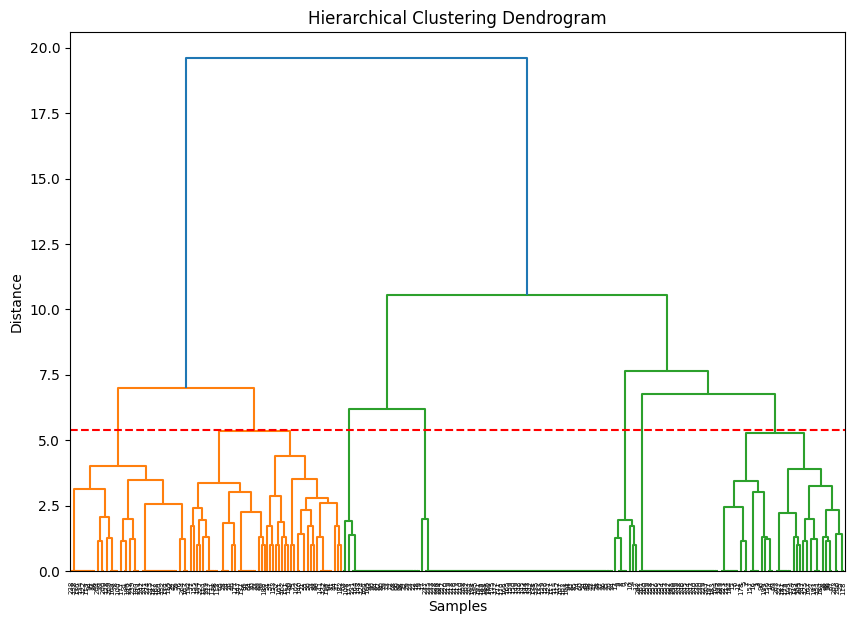

In [273]:
resource_activity_matrix = manual_activities.pivot_table(
    index="org:resource",
    columns="concept:name",
    aggfunc="size",
    fill_value=0,
)

binary_activity_matrix = resource_activity_matrix.applymap(lambda x: 1 if x > 5 else 0)

print(binary_activity_matrix.head())

pca = PCA()
pca_result = pca.fit_transform(binary_activity_matrix)

# hierachical clustering
linkage_matrix = linkage(pca_result, method="ward")
best_silhoutte = -1
optimal_threshold = 0
for threshold in np.arange(0, 60, 0.1):
    clusters = fcluster(linkage_matrix, t=threshold, criterion="distance")
    num_clusters = len(np.unique(clusters))
    if num_clusters == 1:
        continue
    silhouette = silhouette_score(pca_result, clusters)
    penalized_score = silhouette - 0.02 * num_clusters

    if penalized_score > best_silhoutte:
        best_silhoutte = penalized_score
        silhoutte = silhouette
        optimal_clusters = clusters
        optimal_threshold = threshold

print(
    f"Optimal Threshold: {optimal_threshold:.1f} with Silhouette Score: {silhoutte:.3f}: {len(np.unique(optimal_clusters))} Clusters"
)

plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Samples")
plt.ylabel("Distance")
plt.axhline(y=optimal_threshold, color="r", linestyle="--")
plt.show()

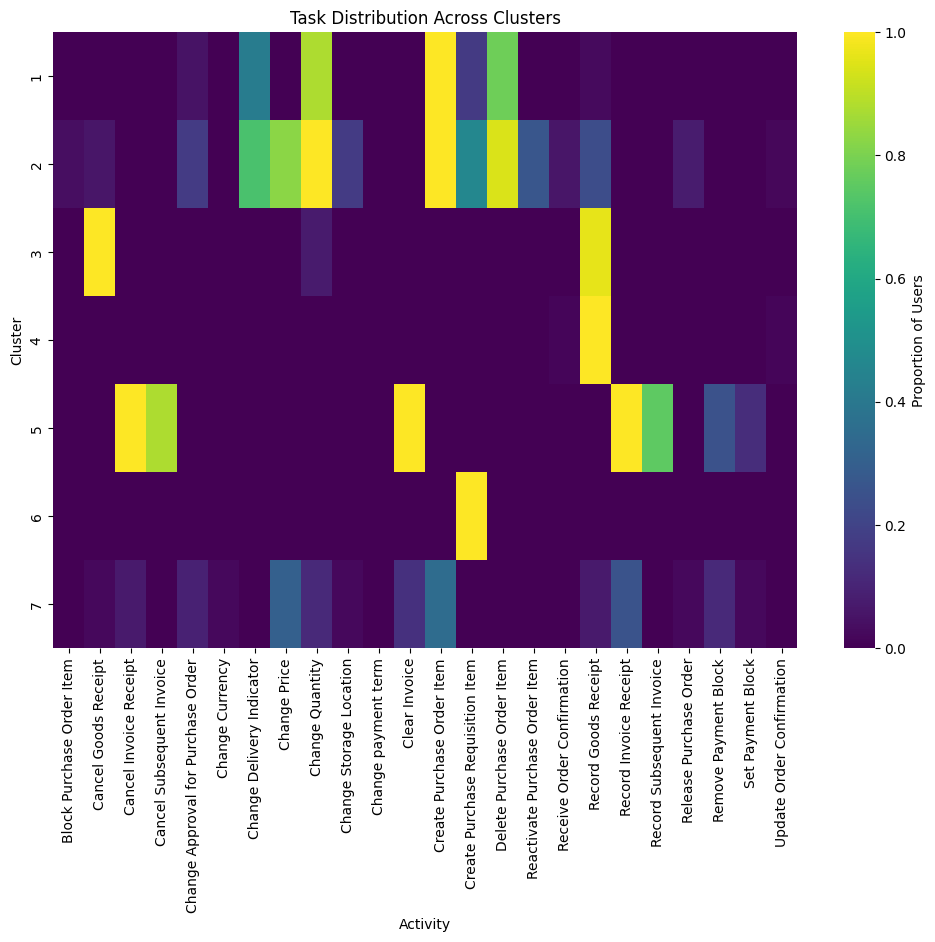

Number of Clusters: 7
Cluster 1: 41 users
Cluster 2: 52 users
Cluster 3: 27 users
Cluster 4: 66 users
Cluster 5: 8 users
Cluster 6: 28 users
Cluster 7: 43 users

Cluster 1:
  - Change Approval for Purchase Order: 4.88%
  - Change Delivery Indicator: 41.46%
  - Change Quantity: 87.80%
  - Create Purchase Order Item: 100.00%
  - Create Purchase Requisition Item: 17.07%
  - Delete Purchase Order Item: 78.05%
  - Record Goods Receipt: 2.44%

Cluster 2:
  - Block Purchase Order Item: 3.85%
  - Cancel Goods Receipt: 5.77%
  - Change Approval for Purchase Order: 17.31%
  - Change Delivery Indicator: 71.15%
  - Change Price: 82.69%
  - Change Quantity: 100.00%
  - Change Storage Location: 17.31%
  - Create Purchase Order Item: 100.00%
  - Create Purchase Requisition Item: 46.15%
  - Delete Purchase Order Item: 94.23%
  - Reactivate Purchase Order Item: 26.92%
  - Receive Order Confirmation: 5.77%
  - Record Goods Receipt: 23.08%
  - Release Purchase Order: 7.69%
  - Update Order Confirmation: 

In [274]:
binary_activity_matrix["Cluster"] = optimal_clusters

# Group by clusters and calculate the mean of activity execution -> e.g. 0.8 -> 80% of the users execute this activity
tasks_per_cluster = binary_activity_matrix.groupby("Cluster").mean()

# Plot a heatmap of task proportions for each cluster
plt.figure(figsize=(12, 8))
sns.heatmap(
    tasks_per_cluster,
    cmap="viridis",
    cbar_kws={"label": "Proportion of Users"},
)
plt.title("Task Distribution Across Clusters")
plt.xlabel("Activity")
plt.ylabel("Cluster")
plt.show()

num_clusters = len(np.unique(optimal_clusters))
print(f"Number of Clusters: {num_clusters}")

cluster_counts = Counter(optimal_clusters)
for cluster_id, count in sorted(cluster_counts.items()):
    print(f"Cluster {cluster_id}: {count} users")

for cluster in tasks_per_cluster.index:
    print(f"\nCluster {cluster}:")
    non_zero_activities = tasks_per_cluster.loc[cluster][
        tasks_per_cluster.loc[cluster] > 0
    ]
    for activity, proportion in non_zero_activities.items():
        print(f"  - {activity}: {proportion:.2%}")

print('\n', binary_activity_matrix[binary_activity_matrix["Cluster"] == 5].index)

users = ["user_002", "user_029"]
selected_data = binary_activity_matrix.loc[users, "Cluster"]

print(selected_data)

print(binary_activity_matrix.loc["user_002"])

The clustering analysis provides valuable insights into the organizational structure and task allocation across different subsidiaries. Clusters 3 and 4 highlight an organizational separation focused on managing delivery confirmations and addressing issues related to received goods, suggesting specialized roles for these activities. Cluster 6, consisting of 28 users exclusively creating Purchase Requisition Items, indicates that this activity is often performed by employees otherwise uninvolved in the process. This implies that initiating purchase requisitions may be widely independent of a specific role within the process scope.

Clusters 1 and 2 reveal broader responsibilities, with 100% involvement in creating Purchase Order Items, combined with related tasks such as making changes or deletions. This pattern suggests that organizational subsidiaries have the flexibility to initiate purchases and modify details when necessary, reflecting a degree of autonomy in managing purchase orders. Cluster 5, on the other hand, focuses on payment process-related tasks, indicating a clear separation into accounting responsibilities.

Cluster 7 appears less distinct and somewhat noisy, grouping individuals who execute a small set of tasks without a clear pattern. However, previous analyses reveal that *user002*, allocated to Cluster 7, stands out as the most active user with significantly higher activity counts. Notably, this user exclusively clears invoices, which likely makes them a key figure for this task. It is possible that *user002* would form its own cluster if absolute activity counts were considered more prominently. The exclusion of these counts in the current clustering analysis may obscure certain patterns, as it fails to capture the unique behavior of highly active users.

To address this limitation, we plan to analyze histograms next. By examining the activity distributions of individual users, we aim to identify additional patterns similar to the one observed for *user002*. This approach will provide further clarity on user roles and responsibilities within the process.

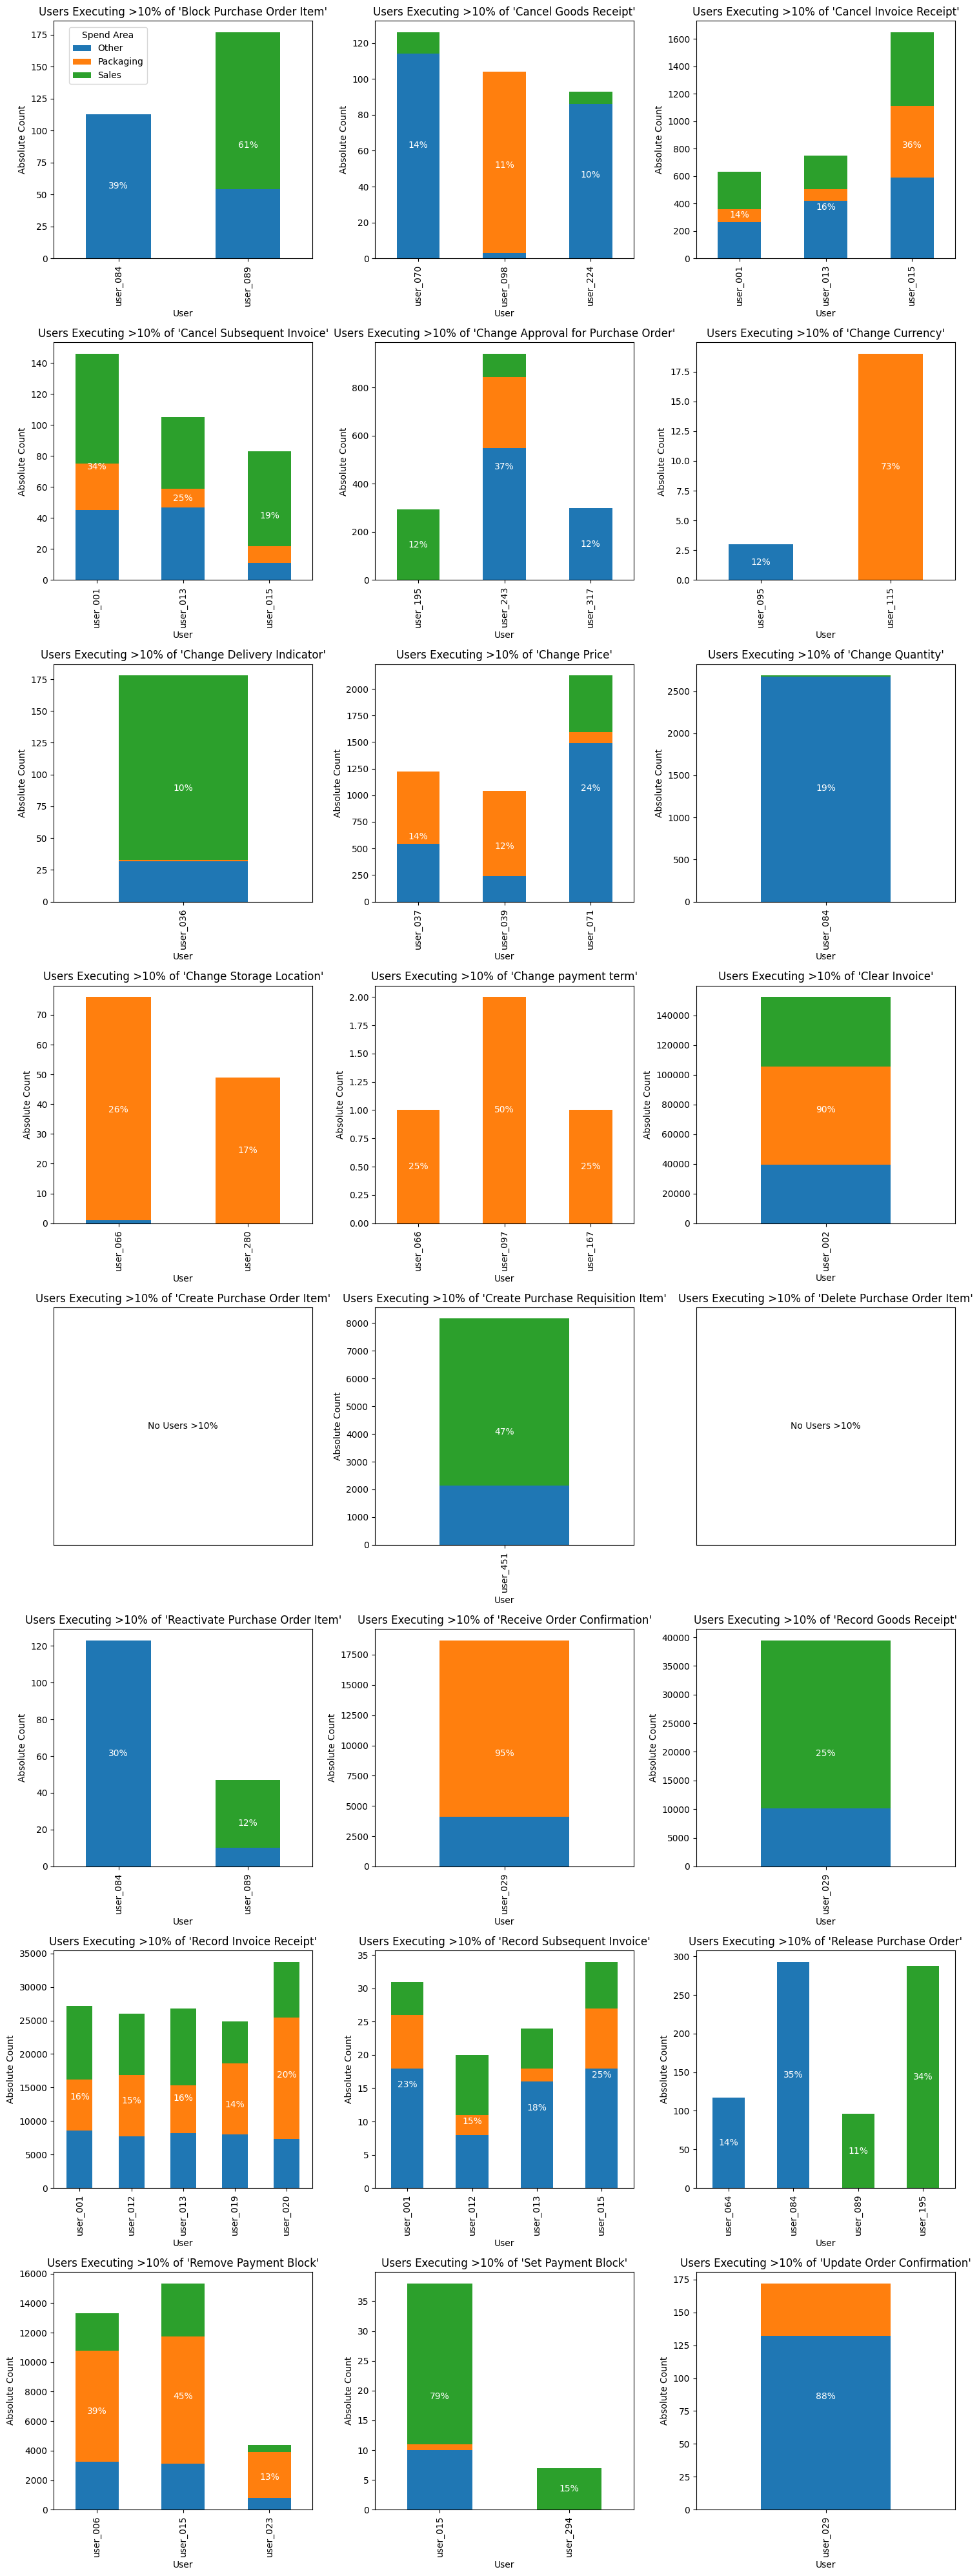

In [275]:
activity_totals = resource_activity_matrix.sum(axis=0)

relative_activity_matrix = resource_activity_matrix.div(activity_totals, axis=1)

activities = resource_activity_matrix.columns
num_activities = len(activities)

n_cols = 3
n_rows = -(-num_activities // n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

spend_area_column = "case:Spend area text"
resource_spend_area_matrix = manual_activities.pivot_table(
    index=["org:resource", spend_area_column],
    columns="concept:name",
    aggfunc="size",
    fill_value=0,
)

for i, activity in enumerate(activities):
    significant_users = relative_activity_matrix[activity] > 0.1
    absolute_counts = resource_activity_matrix.loc[significant_users, activity]
    relative_counts = relative_activity_matrix.loc[significant_users, activity]
    if not absolute_counts.empty:
        stacked_data = (
            resource_spend_area_matrix[activity].unstack().loc[significant_users]
        )
        stacked_data = stacked_data.fillna(0)

        stacked_data.plot(
            kind="bar", stacked=True, ax=axes[i], legend=False
        )

        axes[i].set_title(f"Users Executing >10% of '{activity}'")
        axes[i].set_xlabel("User")
        axes[i].set_ylabel("Absolute Count")
        axes[i].tick_params(axis="x", rotation=90)
        for index, value in enumerate(absolute_counts.values):
            axes[i].text(
                index,
                value / 2,
                f"{relative_counts.iloc[index]:.0%}",
                color="white",
                ha="center",
                va="center",
                fontsize=10,
            )
    else:
        axes[i].text(0.5, 0.5, "No Users >10%", ha="center", va="center")
        axes[i].set_title(f"Users Executing >10% of '{activity}'")
        axes[i].set_xticks([])
        axes[i].set_yticks([])


handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, labels, title="Spend Area", bbox_to_anchor=(0.16, 0.99)
)
plt.tight_layout()
plt.show()

The analysis of task execution reveals clear patterns of specialization, with the most notable results emerging from activities executed most frequently. These high-frequency tasks are critical to the process and highlight centralized roles, functional separations, and varying proportions across spend areas.

For *Clear Invoice*, which occurs over 150,000 times, a single user, *user_002*, is responsible for nearly 90% of executions. This activity is distributed across all spend areas, indicating a centralized accounting responsibility regardless of spend area.

In *Record Invoice Receipt*, five users share the workload, with relative contributions ranging between 15% and 20%. While this activity occurs frequently across all spend areas, the variance in proportions appears largely random, suggesting that the task execution is independent of the spend area. This reinforces the conclusion that the activity is managed through centralized accounting rather than spend area-specific roles.

*Receive Order Confirmation* and *Record Goods Receipt* further reflect centralized responsibility. *user_029* dominates both activities, contributing nearly 95% of *Receive Order Confirmation* and 25% of *Record Goods Receipt*. The former is strongly focused in the Packaging spend area, while the latter is distributed more evenly, with significant proportions in Sales. This suggests that while *user_029* operates centrally, task frequencies still align with spend area priorities. Moreover, in Packaging *Record Goods Receipt* seems to be less centralized and not in the responsibility of *user_029*, indicating a spacial separation. 

In general, task execution across spend areas is not uniform, as some tasks occur far more frequently within specific areas. However, for the most critical activities like *Record Invoice Receipt* and *Clear Invoice*, the distribution of responsibilities points to a centralized accounting function that operates independently of spend area. In contrast, spend area-specific patterns become more pronounced in tasks executed less frequently or those tied to initiating and managing the purchasing process. These tasks, such as Change Quantity or Create Purchase Requisition Item, appear to be driven by the demanding parties spread across various organizational units. This division further strengthens the assumption that while core accounting processes are centralized, the initiation and management of procurement tasks remain decentralized and closely linked to localized spend area priorities.

The insights gained provide a comprehensive understanding of task assignments, responsibilities across spend areas, and the execution of various activities. Notably, we identified a likely spatial separation between the Packaging spend area and the rest. Building on this knowledge, we aim to provide the process owner with a simulation that demonstrates workload scenarios. However, the absence of end timestamps, understandable given the single, transaction nature of the activities—limits the robustness of the results, rendering them more of a proof of concept. To achieve actionable and reliable outcomes, collaboration with a domain expert will be essential.

First, to enable simulation in Apromore, we generated approximate end times for events in the log. Durations were calculated by introducing random variability to a baseline assumption of 5 minutes, which reflects our estimation of the time typically required for the types of tasks at hand. Approximately 2% of events were assigned significantly longer durations, modeled as a normal distribution with a mean of 60 minutes, to account for rare cases involving complexity, delays, or external dependencies.

This approach is rooted in the nature of the activities in the event log, which primarily include transactional or administrative tasks such as creating purchase orders, recording receipts, or clearing invoices. These tasks are generally brief and align well with the assumed 5-minute duration for most cases. While the generated durations are synthetic and intended for demonstration purposes, they likely represent realistic execution times for such processes. Further refinement through domain expertise could improve the accuracy of these assumptions and provide more actionable insights for the process owner.

To account for the degree of automation, we proportionally reduce the duration of automated tasks relative to their level of automation. This approach achieves results similar to those obtained by separating tasks into two roles, user-executed and automated, while maintaining a simpler simulation structure and reducing complexity. Moreover, we use a different duration for vendor related tasks. Without having the domain specific insights of likely durations we decide to use a normal distribution with mean 3 days and std of 4 days with a minimum of 1 hour to simulate vendor reaction times. 

In [279]:
log2 = log_frozen.copy()

# Flatten the relative automation table for merging
relative_automation_flat = (
    relative_automated_activities_spend_area.stack().reset_index()
)
relative_automation_flat.columns = [
    "concept:name",
    "case:Spend area text",
    "automation_level",
]

# Merge the automation levels into the log
log2 = log2.merge(
    relative_automation_flat, on=["concept:name", "case:Spend area text"], how="left"
).fillna(
    0
) 

vendor_tasks = ["Vendor creates debit memo", "Vendor creates invoice"]


# Function to calculate task durations
def calculate_duration(row):
    if row["concept:name"] in vendor_tasks:
        # Vendor task: normal distribution with mean 3 days, std 4 days, minimum 1 hour
        duration = max(
            np.random.normal(
                loc=3 * 24 * 60, scale=4 * 24 * 60
            ),  # Mean and std in minutes
            60,  # Minimum 1 hour
        )
    else:
        # Default task: normal distribution with outliers
        duration = np.maximum(
            np.random.normal(loc=5, scale=1),  # Mean 5min, std 1min
            np.random.choice(
                [1, np.random.normal(60, 10)], p=[0.98, 0.02]
            ),  # Rare long tasks
        )
    # Adjust for automation level
    return duration * (1 - row["automation_level"])

np.random.seed(42)
log2["adjusted_duration"] = log2.apply(calculate_duration, axis=1)

log2["adjusted_duration"] = pd.to_timedelta(log2["adjusted_duration"], unit="m")
log2["time:complete"] = log2["time:timestamp"] + log2["adjusted_duration"]
log2["time:complete"] = pd.to_datetime(log2["time:complete"]).dt.round("s")

log2.to_csv("simulation.csv", index=False)

The generated CSV file contains the original log with imputed end timestamps and serves as the basis for simulation. Building on the findings of this analysis, we introduce a role assignment that aligns with the identified task responsibilities and activity distributions. By defining specific timetables and varying the number of resources allocated to each role, we can simulate different workload scenarios to better understand task assignment and resource utilization.

The goal of this simulation is not to accelerate the process but to achieve more effective task allocation. Specifically, we aim to identify breakeven points where the average simulated process duration aligns with the original durations. This allows us to analyze daily workloads for varying resource configurations and evaluate relative utilizations, ensuring that tasks are better distributed without unnecessary acceleration of payment-related activities. Such insights provide a deeper understanding of task execution and role allocation, helping to optimize resource management while maintaining the intended process timelines.

For the simulation we adjust the nodes slider to 50% since infrequent tasks first mainly belong to the category of activities executed by whoever created the purchase order and second are not relevant and only complicate the role assignment and simulation. In contrast we set the arcs slider to 100% to capture all the given possible workflows according to the discovered process model.